# USD vs. GBP

### Part I : Peeling out the monetary shock

In [1]:
Docker = "To peel out a monetary shocks TS, the data needed are:\n \
          * The federal funds rate series \n \
          * The inflation sequence \n \
          * The output gap sequence."
"""To get the output gap sequence, we use a quadratic function to fit the trend and determine the gap."""
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm

def flashBack(old,n,mode="month"):
    #Get the back the argued period of time
    if mode == "month":
        #Flash back by month
        year = old.year - int((n - n%12)/12)
        res = n%12
        if res >= old.month:
            #We have to go back an extra year
            year = year - 1
            month = 12 + old.month - res
        else:
            month = old.month - res
        result = datetime(year,month,old.day)
    return result

def grabForward(target,domain):
    #Get the closest datetime to the target dt, in the domain time series indexed by the datetimess.
    tmp = domain[target:]
    try:
        return tmp.iloc[0,:].values
    except:
        return tmp.iloc[0]

def grabNearest(target,domain,output=False):
    #Get the colest datetime to the target dt.
    #Domain has to a datetime indexed Series or DataFrame.
    left = domain[:target]
    right = domain[target:]
    if len(left) == 0:
        tt = right.index[0]
    elif len(right) == 0:
        tt = left.index[-1]
    else:
        candidate = [right.index[0],left.index[-1]]
        dev = [abs(x-target) for x in candidate]
        if dev[0] <= dev[1]:
            tt = candidate[0]
        else:
            tt = candidate[1]
    if output == True:
        print("@Function [grabNearest] grabbed tt at %s"%tt)
    if isinstance(domain,pd.Series):
        return domain[tt]
    elif isinstance(domain,pd.DataFrame):
        return domain[tt].values
    else:
        raise ValueError

In [2]:
#Configuration
start = datetime(1994,1,1)
end = datetime(2008,1,1)
regressStart = datetime(1990,1,1)
regressEnd = datetime(2008,1,1)
latex = False
pin_date = 15      #The standing date for month frequecy data entry.

#### Get the output gap time series

In [3]:
#Data inquiry
otpt_raw = pd.read_excel("data/production.xlsx")
otpt = pd.Series(otpt_raw.iloc[:,1].values,index=otpt_raw.iloc[:,0].values,name="industrial_output")[start:end]

In [4]:
#Fitting the quadratic model
regress = pd.DataFrame({'output':otpt})
regress['time'] = np.arange(len(regress))
regress['timesq'] = regress['time']**2
regress['constant'] = 1
model = sm.OLS(regress['output'],regress.drop('output',axis=1))
gapResult = model.fit(cov_type="HC3")
#Get the residual series
output_gap = gapResult.resid
output_gap.index = pd.to_datetime(output_gap.index)
output_gap.name = "outputgap"

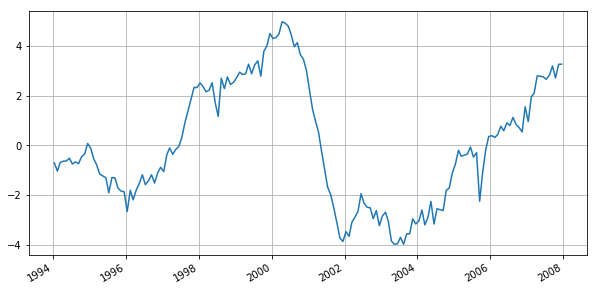

In [5]:
output_gap.plot(figsize=(10,5),grid=True)

In [6]:
#Set the common time line
timeline = output_gap.index

#### Get the inflation time series

In [7]:
#Data inquiry
infl_raw = pd.read_excel("data/inflation.xlsx",skiprows=3)
cpi = pd.Series(infl_raw.iloc[:,1].values,index=infl_raw.iloc[:,0].values,name="cpi")[flashBack(start,1):end]
infl = cpi.pct_change().dropna()

#### Get the federal funds rate

In [8]:
#Data inquiry
iff_raw = pd.read_excel("data/FEDFUNDS.xls",skiprows=10)
iff_tmp = pd.Series(iff_raw['FEDFUNDS'].values,index=iff_raw['observation_date'].values,name = "iff")

In [9]:
#Shaping the series, awkward.
iff1 = pd.Series(np.nan,index=timeline)
for time in timeline:
    iff1[time] = grabForward(target=time,domain=iff_tmp)
head = flashBack(timeline[0],1)
iff1[head] = grabForward(head,iff_tmp)
iff1 = iff1.sort_index()
iff = iff1[iff1.index[1:]]
iff_lag = iff1.shift().dropna()
iff.name = "iffrate"
iff_lag.name = "iffratelag"

#### Run the Taylor's model.

In [10]:
regress = pd.DataFrame([iff,output_gap,infl]).T
regress['Constant'] = 1
taylorModel = sm.OLS(regress.iffrate,regress.drop('iffrate',axis=1))
taylorResult = taylorModel.fit(cov_type="HC3")

In [11]:
estimation = regress.drop("iffrate",axis=1).values.dot(taylorResult.params.values)

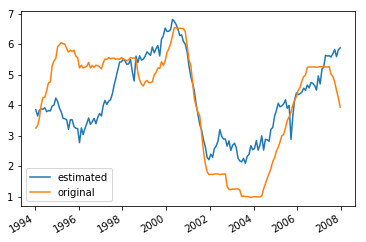

In [12]:
compare = pd.DataFrame({"estimated":estimation,"original":iff},index=timeline)
compare.plot()

#### Peel out the monetary shock of US

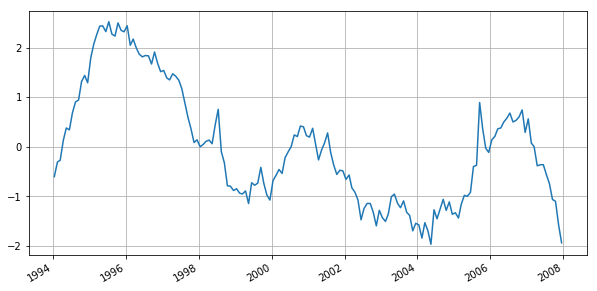

In [13]:
monetaryShock = taylorResult.resid
monetaryShock.name = "monetaryShock"
monetaryShock.plot(figsize=(10,5),grid=True)

### Part II : Get the UIP deviation estimation

In [14]:
"""The way to estimate the deviation from UIP equation is to use a forward difference of spot exchange rate"""

'The way to estimate the deviation from UIP equation is to use a forward difference of spot exchange rate'

In [15]:
#Data inquiry
exch_raw = pd.read_excel("data/exchange_rate.xlsx")
exch = np.log(pd.Series(1/exch_raw["CANADIAN $ TO US $ (WMR) - EXCHANGE RATE"].values,index=exch_raw['Name'].values,name="CADollarPrice"))
interest_raw = pd.read_excel("data/interest_rate.xlsx")
iUS = pd.Series(interest_raw["TR US GVT BMK BID YLD 1Y (U$) - RED. YIELD"].values,index=interest_raw.iloc[:,0].values,name="iUS")
iCA = pd.Series(interest_raw["TR CANADA GVT BMK BID YLD 1Y (C$) - RED. YIELD"].values,index=interest_raw.iloc[:,0].values,name="iCA")

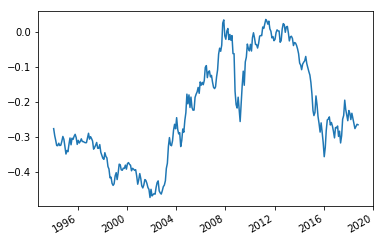

In [16]:
exch.plot()

In [17]:
#Shaping the LHS,RHS,p_t series
pt = pd.Series(np.nan,index=timeline)
sdif = pd.Series(np.nan,index=timeline)
idif = pd.Series(np.nan,index=timeline)

for time in timeline:
    print(time)
    sdif[time] = grabNearest(target=datetime(time.year+1,time.month,time.day),domain=exch) - grabNearest(time,exch)
    idif[time] = grabNearest(time,iUS,True) - grabNearest(time,iCA,True)

pt = sdif-idif

1994-01-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-01-14 00:00:00
@Function [grabNearest] grabbed tt at 1994-01-14 00:00:00
1994-02-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-02-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-02-15 00:00:00
1994-03-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-03-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-03-15 00:00:00
1994-04-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-04-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-04-15 00:00:00
1994-05-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-05-16 00:00:00
@Function [grabNearest] grabbed tt at 1994-05-16 00:00:00
1994-06-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-06-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-06-15 00:00:00
1994-07-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-07-15 00:00:00
@Function [grabNearest] grabbed tt at 1994-07-15 00:00:00
1994-08-15 00:00:00
@Function [grabNearest] grab

@Function [grabNearest] grabbed tt at 2006-07-14 00:00:00
@Function [grabNearest] grabbed tt at 2006-07-14 00:00:00
2006-08-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-08-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-08-15 00:00:00
2006-09-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-09-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-09-15 00:00:00
2006-10-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-10-16 00:00:00
@Function [grabNearest] grabbed tt at 2006-10-16 00:00:00
2006-11-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-11-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-11-15 00:00:00
2006-12-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-12-15 00:00:00
@Function [grabNearest] grabbed tt at 2006-12-15 00:00:00
2007-01-15 00:00:00
@Function [grabNearest] grabbed tt at 2007-01-15 00:00:00
@Function [grabNearest] grabbed tt at 2007-01-15 00:00:00
2007-02-15 00:00:00
@Function [grabNearest] grabbed tt at 2007-02-15

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     4.892
Date:                Mon, 03 Dec 2018   Prob (F-statistic):             0.0284
Time:                        13:53:24   Log-Likelihood:                -232.97
No. Observations:                 166   AIC:                             469.9
Df Residuals:                     164   BIC:                             476.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          0.1735      0.107      1.624

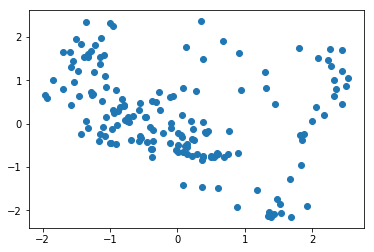

In [18]:
#Regress pt on monetaryShock
if not (pt.index == monetaryShock.index).all(): #Check the index
    raise ValueError
dataset = pd.DataFrame({"UIPdev":pt,"Constant":1,"monetaryShock":monetaryShock}).dropna()
model1 = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock"]])
result1 = model1.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in result1.summary().tables:
        print(line.as_latex_tabular())
print(result1.summary())
plt.scatter(monetaryShock.values,pt.values)

In [19]:
#Adding a exchange rate lag term
exch_lag = exch - exch.shift(3)
intervn = pd.Series([grabNearest(x,exch_lag) for x in timeline],index=timeline,name="intervention")
dataset["intervention"] = intervn
dataset = dataset.dropna()
model2 = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock","intervention"]])
result2 = model2.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in result2.summary().tables:
        print(line.as_latex_tabular())
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     3.076
Date:                Mon, 03 Dec 2018   Prob (F-statistic):             0.0488
Time:                        13:53:24   Log-Likelihood:                -230.97
No. Observations:                 165   AIC:                             467.9
Df Residuals:                     162   BIC:                             477.3
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          0.1511      0.105      1.433

In [20]:
modelInterv = sm.OLS(dataset["UIPdev"],dataset[["Constant","intervention"]])
resultInterv = modelInterv.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in resultInterv.summary().tables:
        print(line.as_latex_tabular())
print(resultInterv.summary())

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.658
Date:                Mon, 03 Dec 2018   Prob (F-statistic):              0.105
Time:                        13:53:24   Log-Likelihood:                -236.67
No. Observations:                 165   AIC:                             477.3
Df Residuals:                     163   BIC:                             483.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Constant         0.1394      0.111      1.251   

In [21]:
dataset["exchgrt"] = pd.Series([grabNearest(x,exch) for x in dataset.index],index=dataset.index,name="exchgrt")
dataset.to_stata("dataset.dta")

# Control the terms in UIP regression.

In [22]:
dataset["sdif"] = sdif
dataset["idif"] = idif

In [23]:
#Dataset1 is a lagged shock and intervention version of original dataset
dataset1 = dataset.copy()

lag_shock,lag_intervention = 6,1
dataset1["monetaryShock"] = dataset1["monetaryShock"].shift(lag_shock)
dataset1["intervention"] = dataset1["intervention"].shift(lag_intervention)
dataset1 = dataset1.dropna()
model3 = sm.OLS(dataset1["sdif"],dataset1[["Constant","monetaryShock","intervention","idif"]])
result3 = model3.fit(cov_type="HAC",cov_kwds={"maxlags":1})
"""
for lag1 in range(1,10):
    for lag2 in range(1,10):
        dataset1 = dataset.copy()
        dataset1["monetaryShock"] = dataset1["monetaryShock"].shift(lag1)
        dataset1["intervention"] = dataset1["intervention"].shift(lag2)
        dataset1 = dataset1.dropna()
        model3 = sm.OLS(dataset1["sdif"],dataset1[["Constant","monetaryShock","intervention","idif"]])
        result3 = model3.fit(cov_type="HAC",cov_kwds={"maxlags":1})
        print("[lag1:%s,lag2:%s] coef of RHS is %s" %(lag1,lag2,result3.pvalues["monetaryShock"]))
result3.bse
"""
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   sdif   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     13.60
Date:                Mon, 03 Dec 2018   Prob (F-statistic):           6.34e-08
Time:                        13:53:24   Log-Likelihood:                 211.44
No. Observations:                 159   AIC:                            -414.9
Df Residuals:                     155   BIC:                            -402.6
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          0.0213      0.007      3.028

In [24]:
if latex == True:
    for line in result3.summary().tables:
        print(line.as_latex_tabular())

In [25]:
UIPmodel = sm.OLS(dataset["sdif"],dataset[["Constant","idif"]])
UIPresult = UIPmodel.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in UIPresult.summary().tables:
        print(line.as_latex_tabular())
UIPresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   sdif   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     9.566
Date:                Mon, 03 Dec 2018   Prob (F-statistic):            0.00233
Time:                        13:53:24   Log-Likelihood:                 210.48
No. Observations:                 165   AIC:                            -417.0
Df Residuals:                     163   BIC:                            -410.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.0157      0.007      2.162      0.031       0.001       0.030
idif          -0.0207      0.007     -3.093      0.002      -0.034      -0.008
==============================================================================
Omnibus:                       12.393   Durbin-Watson:                   0.194
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               32.225
Skew:                          -0.114   Prob(JB):                     1.01e-07
Kurtosis:                       5.153   Cond. No.                         1.16
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [26]:
model4 = sm.OLS(dataset1["UIPdev"],dataset1[["Constant","monetaryShock","intervention"]])
result4 = model4.fit(cov_type="HAC",cov_kwds={"maxlags":1})
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 UIPdev   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5.482
Date:                Mon, 03 Dec 2018   Prob (F-statistic):            0.00500
Time:                        13:53:24   Log-Likelihood:                -212.11
No. Observations:                 159   AIC:                             430.2
Df Residuals:                     156   BIC:                             439.4
Df Model:                           2                                         
Covariance Type:                  HAC                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          0.1096      0.099      1.101      0.271      -0.085       0.305
monetaryShock    -0.3092      0.105     -2.947      0.003      -0.515      -0.104
intervention      2.9882      2.683      1.114      0.265      -2.270       8.247
==============================================================================
Omnibus:                        8.594   Durbin-Watson:                   0.072
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                5.256
Skew:                           0.278   Prob(JB):                       0.0722
Kurtosis:                       2.304   Cond. No.                         37.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [27]:
model5 = sm.OLS(dataset1["UIPdev"],dataset1[["Constant","monetaryShock","intervention"]])
result5 = model5.fit(cov_type="HAC",cov_kwds={"maxlags":1})
if latex == True:
    for line in result5.summary().tables:
        print(line.as_latex_tabular())
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 UIPdev   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5.482
Date:                Mon, 03 Dec 2018   Prob (F-statistic):            0.00500
Time:                        13:53:24   Log-Likelihood:                -212.11
No. Observations:                 159   AIC:                             430.2
Df Residuals:                     156   BIC:                             439.4
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant          0.1096      0.099      1.101

In [28]:
dataset1.to_stata("dataset1.dta")

In [29]:
dataset["monetaryShock_lag1"] = dataset["monetaryShock"].shift()
dataset["monetaryShock_lag2"] = dataset["monetaryShock_lag1"].shift()
dataset["monetaryShock_lag3"] = dataset["monetaryShock_lag2"].shift()
dataset["monetaryShock_lag4"] = dataset["monetaryShock_lag3"].shift()
dataset["monetaryShock_lag5"] = dataset["monetaryShock_lag4"].shift()

dataset = dataset.dropna()
dynamicModel = sm.OLS(dataset["UIPdev"],dataset[["Constant","monetaryShock","monetaryShock_lag1","monetaryShock_lag2",
                                                "monetaryShock_lag3","monetaryShock_lag4","monetaryShock_lag5"]])
dynamicResult = dynamicModel.fit(cov_type="HAC",cov_kwds={"maxlags":1})
dynamicResult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 UIPdev   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1.724
Date:                Mon, 03 Dec 2018   Prob (F-statistic):              0.119
Time:                        13:53:25   Log-Likelihood:                -214.56
No. Observations:                 160   AIC:                             443.1
Df Residuals:                     153   BIC:                             464.6
Df Model:                           6                                         
Covariance Type:                  HAC                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant               0.1341      0.105      1.277      0.202      -0.072       0.340
monetaryShock          0.0709      0.305      0.233      0.816      -0.526       0.668
monetaryShock_lag1    -0.0933      0.290     -0.322      0.747      -0.661       0.474
monetaryShock_lag2     0.0992      0.300      0.330      0.741      -0.490       0.688
monetaryShock_lag3     0.0327      0.288      0.113      0.910      -0.533       0.598
monetaryShock_lag4    -0.0947      0.271     -0.349      0.727      -0.627       0.437
monetaryShock_lag5    -0.3301      0.254     -1.302      0.193      -0.827       0.167
==============================================================================
Omnibus:                        9.173   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                5.567
Skew:                           0.290   Prob(JB):                       0.0618
Kurtosis:                       2.293   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

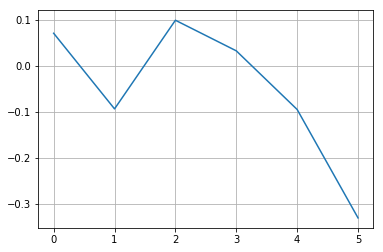

In [30]:
plt.plot(np.arange(6),dynamicResult.params.iloc[1:].values)
plt.grid(True)

In [31]:
dataset

,UIPdev,Constant,monetaryShock,intervention,exchgrt,sdif,idif,monetaryShock_lag1,monetaryShock_lag2,monetaryShock_lag3,monetaryShock_lag4,monetaryShock_lag5
1994-09-15,0.784237,1,0.947182,0.005842,-0.311374,0.014237,-0.77,0.906975,0.682370,0.344163,0.382155,0.131223
1994-10-15,0.816106,1,1.319958,0.025869,-0.297880,0.006106,-0.81,0.947182,0.906975,0.682370,0.344163,0.382155
1994-11-15,0.454871,1,1.443148,0.016865,-0.306160,0.004871,-0.45,1.319958,0.947182,0.906975,0.682370,0.344163
1994-12-15,1.185212,1,1.295345,-0.014398,-0.325772,0.005212,-1.18,1.443148,1.319958,0.947182,0.906975,0.682370
1995-01-15,1.759020,1,1.796289,-0.050168,-0.348048,0.039020,-1.72,1.295345,1.443148,1.319958,0.947182,0.906975
1995-02-15,1.511483,1,2.081557,-0.031811,-0.337971,0.021483,-1.49,1.796289,1.295345,1.443148,1.319958,0.947182
1995-03-15,1.729211,1,2.262053,-0.015545,-0.341318,0.029211,-1.70,2.081557,1.796289,1.295345,1.443148,1.319958
1995-04-15,1.695148,1,2.439265,0.028213,-0.319835,0.015148,-1.68,2.262053,2.081557,1.796289,1.295345,1.443148
1995-05-15,1.219851,1,2.443797,0.035721,-0.302250,-0.010149,-1.23,2.439265,2.262053,2.081557,1.796289,1.295345
1995-06-15,1.019176,1,2.329227,0.019669,-0.321649,0.009176,-1.01,2.443797,2.439265,2.262053,2.081557,1.796289
